# Sparkify Churn Prediction

## 1. Load and clean dataset
Loading and cleaning the dataset, checking for invalid or missing data - for example, records without user IDs or session IDs.

In [244]:
# Import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, udf, from_unixtime, substring
from pyspark.sql.types import LongType, IntegerType

import pandas as pd
import matplotlib.pyplot as plt

In [104]:
# Correct autocomplete not working
%config Completer.use_jedi = False

In [105]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [106]:
# Spark UI at localhost:4040
spark

In [276]:
# Read in full sparkify dataset

event_data = 'mini_sparkify_event_data.json'
users_log = spark.read.json(event_data)

In [ ]:
# Full dataset (12 Gb, 20 million rows)
# event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'

# Mini dataset (128 Mb, 200 thousand rows, 1% of the full dataset)
# event_data = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

# df = spark.read \
#     .option('encoding', 'ISO-8859-1') \
#     .option('lineSep', '\n') \
#     .json(event_data)

# Encodings tried:
# iso-8859-1
# latin1
# cp1252

In [108]:
users_log.createOrReplaceTempView('log_table')
spark.sql(
    """
    SELECT
        artist,
        song
    FROM
        log_table
    WHERE
        userID = 124
        and sessionId = 420
        and itemInSession = 57
    """).show(truncate=False)

+-----------------+---------------------------+
|artist           |song                       |
+-----------------+---------------------------+
|ÃÂlafur Arnalds|HÃÂ¦gt_ kemur ljÃÂ³siÃÂ°|
+-----------------+---------------------------+



In [277]:
print('df shape:', (users_log.count(), len(users_log.columns)))

df shape: (286500, 18)


In [278]:
users_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [279]:
# Adjust the data types

users_log = users_log.withColumn('registration', from_unixtime(col('registration') / 1000))
users_log = users_log.withColumn('ts', from_unixtime(col('ts') / 1000))
users_log = users_log.withColumn('userId', col('userId').cast(LongType()))

In [281]:
users_log.limit(5).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Rockpools,200,2018-09-30 21:01:57,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 15:20:30,8,Canada,200,2018-09-30 21:03:00,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Time For Miracles,200,2018-09-30 21:06:34,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,2018-09-30 15:20:30,8,Knocking On Forbidden Doors,200,2018-09-30 21:06:56,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,2018-09-28 19:22:42,29,Harder Better Faster Stronger,200,2018-09-30 21:11:16,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [282]:
users_log.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,278154
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.11718197783722,None,None,None,None,None,1041.526554973822,Infinity,210.05459685863875,None,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201141085,None,99.23517921058324,None,None,None,None,None,726.7762634630834,NaN,31.50507848842202,None,None,109091.94999910519
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,2018-03-18 10:44:35,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,2018-09-30 21:01:57,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",2
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,2018-11-26 13:49:14,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,2018-12-02 23:11:16,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300025


In [283]:
users_log_valid = users_log.dropna(how='any', subset=['userId', 'sessionId'])

old_rows, old_columns = users_log.count(), users_log.columns
new_rows, new_columns = users_log_valid.count(), users_log_valid.columns

print('users_log shape:\t', (old_rows, len(old_columns)))
print('users_log_valid shape:\t', (new_rows, len(new_columns)))
print('{} rows with empty user and session IDs removed'.format(old_rows - new_rows))

users_log shape:	 (286500, 18)
users_log_valid shape:	 (278154, 18)
8346 rows with empty user and session IDs removed


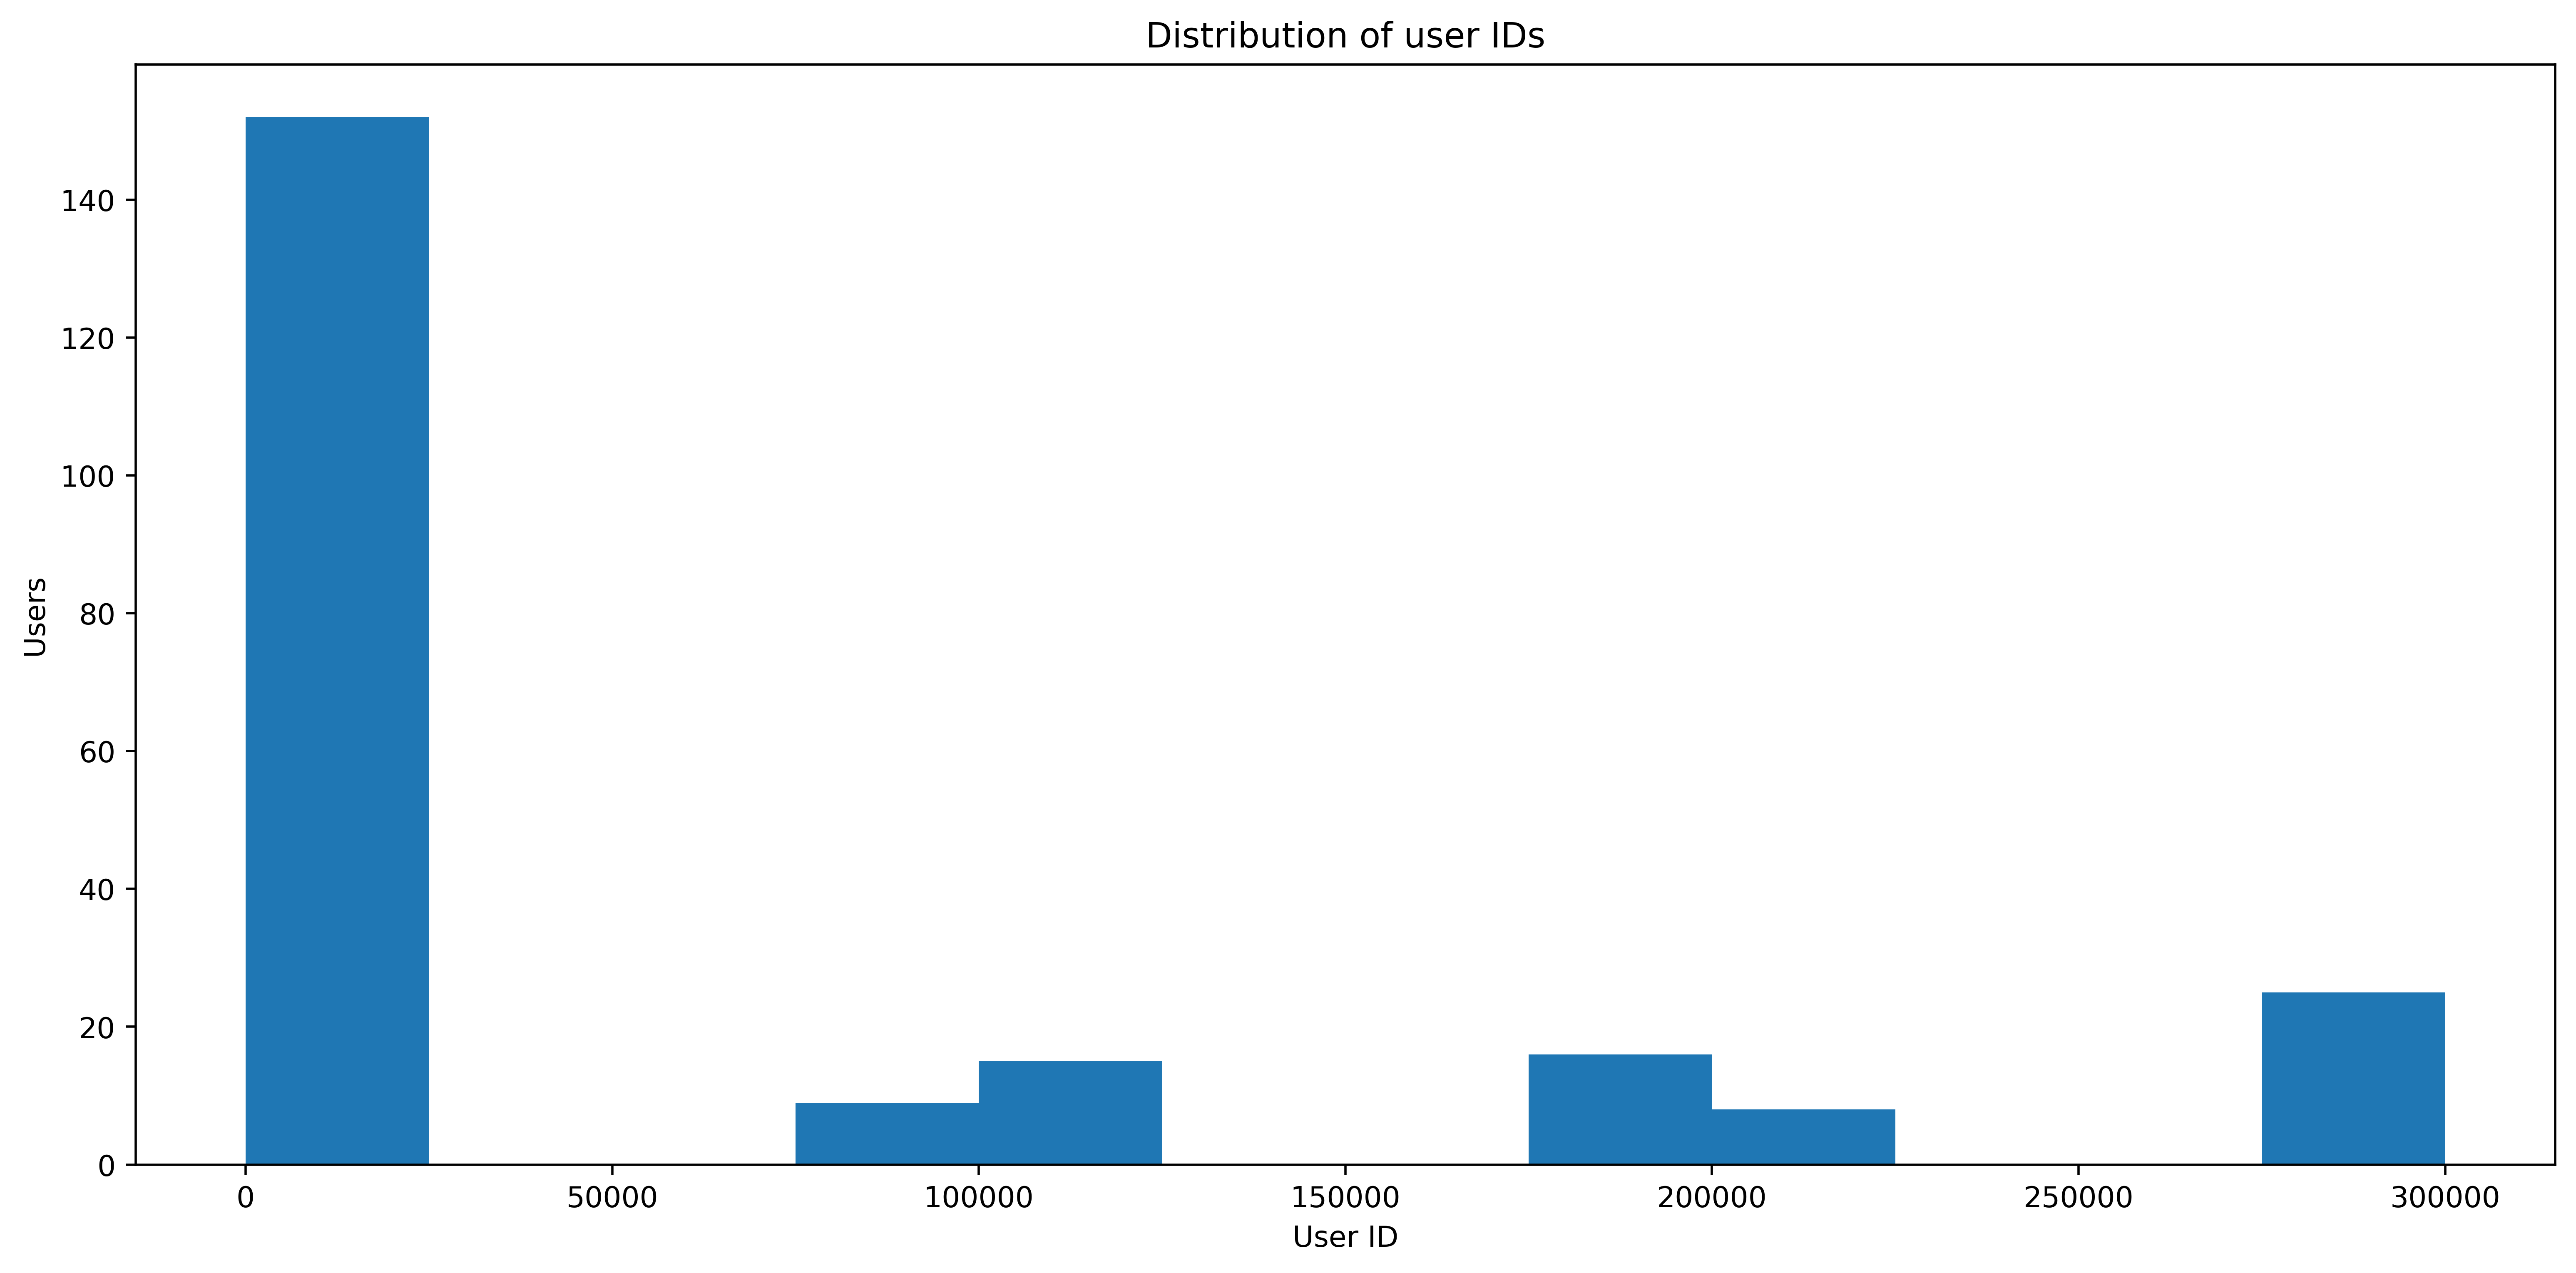

In [139]:
# DELETE THIS CELL

plt.figure(figsize=(15, 7), dpi=500)

plt.hist(users_log_valid.select('userID').dropDuplicates().toPandas(), bins=12)
plt.xlabel('User ID')
plt.ylabel('Users')
plt.title('Distribution of user IDs')

plt.show();

In [153]:
distinct_user_ids = users_log_valid.dropDuplicates(['userId']).count()
print('Distinct user IDs:', distinct_user_ids)

Distinct user IDs: 225


In [300]:
def print_column_period(df, column):
    """Prints the earliest and latest dates present in a given dataframe column.
    
    Parameters:
        df (Spark dataframe): 
        column (String):
    
    Returns:
        start_period (Same as input type): Earliest date from the given column.
        end_period (Same as input type): Latest date from the given column.
    """
    
    start_period = users_log_valid.select([column]).orderBy(column).limit(1).collect()[0][0]
    end_period = users_log_valid.select([column]).orderBy(column, ascending=False).limit(1).collect()[0][0]
    
    print('Earliest {}:\t'.format(column), start_period)
    print('Latest {}:\t'.format(column), end_period)
    
    return

In [301]:
# Reiterate important periods from the dataframe, also shown previously with the describe().

print_column_period(users_log, 'registration')
print_column_period(users_log, 'ts')

Earliest registration:	 2018-03-18 10:44:35
Latest registration:	 2018-11-26 13:49:14
Earliest ts:	 2018-09-30 21:01:57
Latest ts:	 2018-12-02 23:11:16


## 2. Exploratory Data Analysis

### Defining Churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [170]:
# DELETE THIS CELL

df_valid.createOrReplaceTempView('log_table')
spark.sql(
    """
    WITH
    user_group as
        (
        SELECT
            userId,
            CASE
                WHEN userId > 0 AND userId < 50000 THEN 1
                WHEN userId >= 50000 AND userId < 150000 THEN 2
                WHEN userId >= 150000 AND userId < 250000 THEN 3
                WHEN userId >= 250000 AND userId <= 300025 THEN 4
                ELSE 5
            END as userGroup,
            song
        FROM
            log_table
        WHERE
            song IS NOT NULL
        )
    SELECT
        userGroup,
        count(DISTINCT userId) as users,
        count(song) as songs,
        count(song)/count(DISTINCT userId) as songsPerUser
    FROM
        user_group
    GROUP BY
        userGroup
    ORDER BY
        userGroup
    """).show(truncate=False)

+---------+-----+------+------------------+
|userGroup|users|songs |songsPerUser      |
+---------+-----+------+------------------+
|1        |152  |171638|1129.1973684210527|
|2        |24   |9640  |401.6666666666667 |
|3        |24   |16798 |699.9166666666666 |
|4        |25   |30032 |1201.28           |
+---------+-----+------+------------------+



In [ ]:
# DELETE THIS CELL

df_valid.createOrReplaceTempView('log_table')
spark.sql(
    """
    SELECT
        userId,
        sessionId,
        itemInSession
    FROM
        log_table
    WHERE
        page = 'Cancellation Confirmation'
        --userId = 73
        --and sessionId = 1059
        --and itemInSession = 
    """).show(30, truncate=False)

# userId 
# +------+---------+-------------+
# |userId|sessionId|itemInSession|
# +------+---------+-------------+
# |18    |514      |104          |
# |32    |540      |56           |
# |125   |174      |10           |
# |105   |508      |332          |
# |17    |797      |273          |
# |143   |843      |29           |
# |101   |842      |145          |
# |129   |802      |34           |
# |121   |881      |287          |
# |51    |934      |176          |
# |87    |1092     |100          |
# |122   |1029     |43           |
# |12    |1072     |72           |
# |58    |1112     |48           |
# |73    |1059     |11           |
# |3     |1324     |46           |
# |106   |1383     |18           |
# |103   |1583     |8            |
# |28    |1519     |306          |
# |54    |1819     |42           |
# |29    |1864     |49           |
# |70    |1940     |91           |
# |53    |2003     |110          |
# |100011|40       |22           |
# |100001|53       |23           |
# |100024|42       |36           |
# |100006|6        |45           |
# |100019|71       |65           |
# |100003|86       |81           |
# |100023|109      |18           |
# +------+---------+-------------+

In [284]:
flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
users_log_valid = users_log_valid.withColumn('churn', flag_cancellation_event('page'))

### Exploring Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
def group_by_count_column(df, column):
    """Perform a group by and count the values from a desired column.
    
    Parameters:
        df (Spark dataframe): The dataframe that contains the column.
        column (String): The name of the column, from the df, to perform the group by and count its values.
    
    Returns:
        None.
    """
    
    df.select(column).groupby(column).count().orderBy('count', ascending=False).show(truncate=False)
    
    return

In [17]:
categorical_columns = ['artist', 'auth', 'gender', 'method', 'page', 'song', 'status']

for column in categorical_columns:
        group_by_count_column(df_valid, column)

+----------------------+-----+
|artist                |count|
+----------------------+-----+
|null                  |50046|
|Kings Of Leon         |1841 |
|Coldplay              |1813 |
|Florence + The Machine|1236 |
|Dwight Yoakam         |1135 |
|BjÃÂ¶rk              |1133 |
|The Black Keys        |1125 |
|Muse                  |1090 |
|Justin Bieber         |1044 |
|Jack Johnson          |1007 |
|Eminem                |953  |
|Radiohead             |884  |
|Alliance Ethnik       |876  |
|Train                 |854  |
|Taylor Swift          |840  |
|OneRepublic           |828  |
|The Killers           |822  |
|Linkin Park           |787  |
|Evanescence           |781  |
|Harmonia              |729  |
+----------------------+-----+
only showing top 20 rows

+---------+------+
|auth     |count |
+---------+------+
|Logged In|278102|
|Cancelled|52    |
+---------+------+

+------+------+
|gender|count |
+------+------+
|F     |154578|
|M     |123576|
+------+------+

+------+------+
|m

In [ ]:
df_valid.createOrReplaceTempView('log_table')
df_valid = spark.sql(
    """
    SELECT
        *,
        to_date(from_unixtime(registration / 1000)) as registration,
        substring(to_date(from_unixtime(registration / 1000)), 1, 7) as cohort
    FROM
        log_table
    ORDER BY
        registration
    """)

In [221]:
user_acquisition = users_log_valid.select(['userId', 'registration']).dropDuplicates()
user_acquisition = user_acquisition.select(['registration']).orderBy('registration')
user_acquisition = user_acquisition.withColumn('registration', (col('registration') / 1000))

x = user_acquisition.withColumn('registration', from_unixtime('registration')).toPandas()['registration'].tolist()
y = list(range(1, len(x) + 1))

In [ ]:
plt.figure(figsize=(14, 7), dpi=500)
plt.plot(x, y)
plt.xlabel('Number of latent features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of latent features');

## 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [258]:
users_log.select(['userId', 'userAgent']).dropDuplicates(['userId']).show(truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|userId|userAgent                                                                                                                                  |
+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|26    |Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                   |
|29    |"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                    |
|65    |Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       |
|100016|"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safar

## 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 5. Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.